In [1]:
# resp = requests.get('https://api.kraken.com/0/public/Spread?pair=XBTUSD')
import pandas as pd
import requests
import numpy as np

import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
def get_data(length=25):
    resp = requests.get(f'https://api.kraken.com/0/public/Depth?count={length}&pair=XBTUSD')
    t = pd.Timestamp.now()
    data = resp.json()['result']['XXBTZUSD']
    
    return data, t

In [3]:
# print(resp.json())

In [4]:
def build_dVt(df):
    bid_condition = [
        df.bid_price < df.bid_price.shift(-1),
        df.bid_price == df.bid_price.shift(-1),
        df.bid_price > df.bid_price.shift(-1),
    ]
    
    bid_res = [
        0,
        df.bid_volume.diff(-1),
        df.bid_volume
    ]
    
    ask_condition = [
        df.ask_price < df.ask_price.shift(-1),
        df.ask_price == df.ask_price.shift(-1),
        df.ask_price > df.ask_price.shift(-1),
    ]
    
    ask_res = [
        df.ask_volume,
        df.ask_volume.diff(-1),
        0
    ]
    
    dVtB = pd.Series(np.select(bid_condition, bid_res, np.nan), name='dVtB')
    dVtA = pd.Series(np.select(ask_condition, ask_res, np.nan), name='dVtA')
    return dVtB, dVtA

In [5]:
def create_df(data):
    def make_basic_table(data, kind):
        df = pd.DataFrame(data=data, columns=[f'{kind}_price', f'{kind}_volume', f'{kind}_time'])
        df[f'{kind}_price'] = df[f'{kind}_price'].astype('float32')
        df[f'{kind}_volume'] = df[f'{kind}_volume'].astype('float32')
        df[f'{kind}_time'] = pd.to_datetime(df[f'{kind}_time'],unit='s') 
        return df
    asks = data['asks']
    bids = data['bids']
    asks_df = make_basic_table(asks, 'ask')
    bids_df = make_basic_table(bids, 'bid')
    
    df = pd.merge(bids_df, asks_df, left_index=True, right_index=True, how='outer')
    df['spread'] = df.ask_price - df.bid_price
    
    dVtB, dVtA = build_dVt(df)
    
    df = df.join(dVtB)
    df = df.join(dVtA)
    
    df['VOI'] = df.dVtB - df.dVtA
    df['OIR'] = df.VOI / (df.dVtB + df.dVtA)
    df['M'] = 0.5*(df.bid_price + df.ask_price)
    df['dM'] = df.M.diff(-1)
    
    return df
    

In [10]:
df = create_df(get_data()[0])

In [11]:
df.head()

,bid_price,bid_volume,bid_time,ask_price,ask_volume,ask_time,spread,dVtB,dVtA,VOI,OIR,M,dM
0,19583.199219,12.017,2022-10-14 08:57:49,19583.300781,0.118,2022-10-14 08:57:44,0.101562,12.017,0.118,11.899,0.980552,19583.250000,-2.300781
1,19583.099609,4.076,2022-10-14 08:57:49,19588.000000,0.180,2022-10-14 08:57:47,4.900391,4.076,0.180,3.896,0.915414,19585.550781,0.101562
2,19582.800781,12.767,2022-10-14 08:57:48,19588.099609,0.950,2022-10-14 08:57:46,5.298828,12.767,0.950,11.817,0.861486,19585.449219,-0.500000
3,19581.699219,0.001,2022-10-14 08:57:45,19590.199219,1.784,2022-10-14 08:57:47,8.500000,0.001,1.784,-1.783,-0.998879,19585.949219,-0.050781
4,19581.599609,0.001,2022-10-14 08:57:48,19590.400391,1.144,2022-10-14 08:57:42,8.800781,0.001,1.144,-1.143,-0.998253,19586.000000,0.199219


In [6]:
def save_ar_plot(df, col, i, max_t, cur_t):

    plt.figure(figsize=(12, 8), facecolor=(1, 1, 1))
    plot_acf(df[col].dropna(), title=f'{col} AR {max_t}||{cur_t}', lags=20);
    
    plt.savefig(f'./plot/{col}/{i}.jpg', bbox_inches='tight', dpi=100)
    plt.close()
    
def save_reg_plot(df, x, y):
    plt.figure(figsize=(12, 8), facecolor=(1, 1, 1))
    sns.regplot(x, y, data=df);
    plt.savefig(f'./plot/reg/{y}vs{x}_{i}.jpg', bbox_inches='tight', dpi=100)
    plt.close()

In [6]:
import matplotlib.animation as animation
import matplotlib.image as mpimg
from pathlib import Path

def create_movie(name, fps=4, dpi=150, low=0, high=60, interval=1):
    
    path = Path(f'./plot/{name}')
    imgs = []
    fig = plt.figure()
    plt.axis('off')

    for i in range(low, high, interval):
        img = mpimg.imread(path/f'{i}.jpg')
        img = plt.imshow(img, animated=True)
        imgs.append([img])
    ani = animation.ArtistAnimation(fig, imgs, interval=1000/fps, blit=True)
    ani.save(f'{name}.mp4', fps=fps, dpi=dpi)
    plt.close()

$OI_{t} = \delta V_{t}^{B} - \delta V_{t}^{A}$


In [7]:
import time

In [8]:
times = []
all_data = []
for i in range(60):
    data, t = get_data()
    times.append(t)
#     asks, bids = data['asks'], data['bids']
    all_data.append(data)
    time.sleep(1)

In [9]:
for i, data in enumerate(all_data):    
    df = create_df(data)
    tt = max(df.ask_time.max(), df.bid_time.max())
    tt = str(tt).split()[1]
    t = str(times[i]).split()[1][:-4]
    save_ar_plot(df, 'VOI', i, tt, t)
    save_ar_plot(df, 'OIR', i, tt, t)
    save_ar_plot(df, 'M', i, tt, t)
    save_ar_plot(df, 'dM', i, tt, t)
#     save_reg_plot(df, 'VOI', 'dM')

for x in ['VOI', 'OIR', 'M', 'dM']:
    create_movie(x, fps=1, dpi=150, low=0, high=60)

C:\Users\crxim\Anaconda3\envs\torch\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\crxim\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
# times

<AxesSubplot:xlabel='VOI', ylabel='dM'>

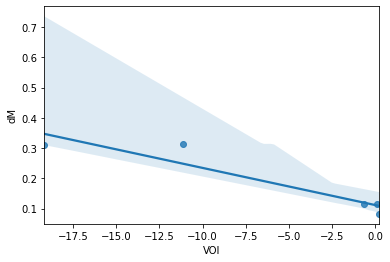

In [17]:
%matplotlib inline
# dM(t, 20) vs VOI
sns.regplot(df.VOI[:5], df.dM.rolling(20).mean().dropna(),)

<AxesSubplot:xlabel='VOI', ylabel='dM'>

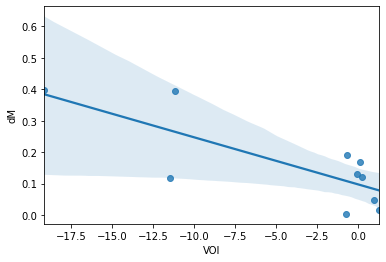

In [30]:
sns.regplot(df.VOI[:10], df.dM.rolling(15).mean().dropna(),)

<AxesSubplot:xlabel='VOI', ylabel='dM'>

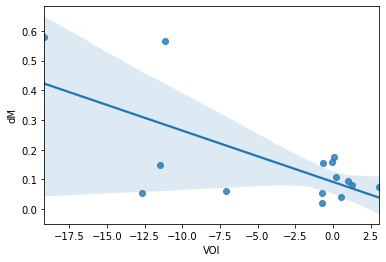

In [29]:
# dM(t, 15) vs VOI
sns.regplot(df.VOI[:15], df.dM.rolling(10).mean().dropna(),)

<AxesSubplot:xlabel='OIR', ylabel='dM'>

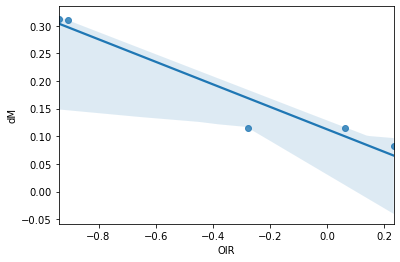

In [18]:
# dM(t, 20) vs OIR
sns.regplot(df.OIR[:5], df.dM.rolling(20).mean().dropna(),)

In [15]:
# sns.regplot('VOI', 'dM', data=df)

<AxesSubplot:xlabel='VOI', ylabel='dM'>

In [26]:
df.dM.rolling(20).mean().dropna()

19    0.309961
20    0.312500
21    0.114941
22    0.115039
23    0.082422
Name: dM, dtype: float64

In [39]:
R_series = []
best_dt = 0
for dt in range(3, 20):
    x = df.VOI[:dt].values #.dropna()
    y = df.dM.rolling(25-dt).mean().dropna().values
    x = sm.add_constant(x)

    model = sm.OLS(y, x).fit()
    predictions = model.predict(x)
    R2 = model.rsquared
    R_series.append(R2)
#     print(model.summary())

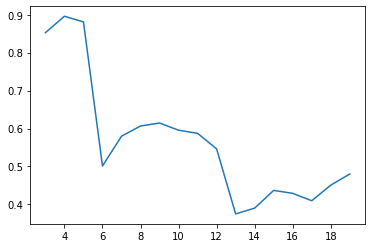

In [47]:
plt.plot(range(3, len(R_series)+3), R_series)

In [33]:
model.rsquared

0.8809561238372932

In [48]:
R_series = []
best_dt = 0
for dt in range(3, 20):
    x = df.OIR[:dt].values #.dropna()
    y = df.dM.rolling(25-dt).mean().dropna().values
    x = sm.add_constant(x)

    model = sm.OLS(y, x).fit()
    predictions = model.predict(x)
    R2 = model.rsquared
    R_series.append(R2)

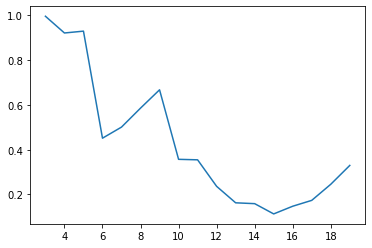

In [49]:
plt.plot(range(3, len(R_series)+3), R_series)

In [17]:
# sns.regplot('OIR', 'dM', data=df)

<AxesSubplot:xlabel='OIR', ylabel='dM'>

In [18]:
# x = df.OIR.dropna()
# y = df.dM.dropna()
# x = sm.add_constant(x)

# model = sm.OLS(y, x).fit()
# predictions = model.predict(x) 
# print(model.summary())